In [37]:
import pickle
import re
import os

import random
import numpy as np
import torch
from random import shuffle
import argparse
import pickle

import collections
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from util.args_parser import parser
from model.QACGBERT import BertConfig
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler, SequentialSampler, WeightedRandomSampler
from tqdm import tqdm, trange

from util.optimization import BERTAdam
from util.processor import (Sentihood_NLI_M_Processor,
                            Semeval_NLI_M_Processor,
                            Persent_Processor)

from util.tokenization import *

from util.evaluation import *

from util.train_helper import *

from model.QACGLONG import *

## Logbook Visual

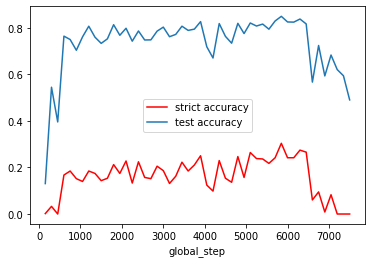

The best otained strict accuracy is 0.3039723661485319
The best otained test accuracy is 0.8497409326424871


In [2]:
def process_log(data):
    data.reset_index(inplace=True)
    data.drop(['s_auc'], axis=1, inplace=True)
    data.columns = ['epoch', 'global_step', 'loss', 't_loss', 't_acc', 'strict_acc', 'f1', 'auc', 's_acc', 's_auc']
    data.drop(['loss', 'auc', 's_acc', 's_auc'], axis=1, inplace=True)
    data.drop_duplicates(inplace=True)
    return data

data1 = pd.read_csv('../results/persent/7aspects_lr_1e-4+allsamples/7aspects_lr_1e-4+allsamples_noerror_Pretrained_20epoch/log.txt', sep="\t")
data1 = process_log(data1)

# data2 = pd.read_csv('../results/persent/lr_1e-4+7000sample2/log.txt', sep="\t")
# data2 = process_log(data2)

# data3 = pd.read_csv('../results/persent/lr_1e-4+7000sample3/log.txt', sep="\t")
# data3 = process_log(data3)

# data4 = pd.read_csv('../results/persent/lr_1e-4+7000sample4/log.txt', sep="\t")
# data4 = process_log(data4)

# data5 = pd.read_csv('../results/persent/lr_1e-4+7000sample5/log.txt', sep="\t")
# data5 = process_log(data5)

# data = pd.concat([data1, data2, data3, data4, data5])
df = data1

sns.lineplot(data=df, x="global_step", y="strict_acc", color="red", label="strict accuracy")
sns.lineplot(data=df, x="global_step", y="t_acc", label="test accuracy")
plt.legend()
plt.ylabel("")
plt.show()

print(f'The best otained strict accuracy is {max(df.strict_acc)}')
print(f'The best otained test accuracy is {max(df.t_acc)}')

## Aspect-level Visual

In [2]:
args_init = ['--task_name', 'persent', 
             '--data_dir', '../datasets/persent/',
             '--output_dir', '../results/persent/QACGLONG-reproduce2/',
             '--model_type', 'QACGLONG',
             '--do_lower_case',
             '--max_seq_length', '2048',
             '--train_batch_size', '64',
             '--eval_batch_size', '10',
             '--learning_rate', '1e-4',
             '--num_train_epochs', '10',
             '--vocab_file', 'BERT-Google/vocab.txt',
             '--bert_config_file', 'Longformer/config.json',
             '--init_checkpoint', '../results/persent/7aspects_lr_1e-4+allsamples/7aspects_lr_1e-4+allsamples_noerror_Pretrained_20epoch/best_checkpoint.bin', 
             '--seed', '123',
             '--evaluate_interval', '150',
             '--accumulate_gradients', '8',
             '--gradient_accumulation_steps', '8']

# args_init = ['--task_name', 'persent', 
#              '--data_dir', '../datasets/persent/',
#              '--output_dir', '../results/persent/QACGBERT-reproduce5/',
#              '--model_type', 'QACGBERT',
#              '--do_lower_case',
#              '--max_seq_length', '128',
#              '--train_batch_size', '32',
#              '--eval_batch_size', '64',
#              '--learning_rate', '2e-5',
#              '--num_train_epochs', '30',
#              '--vocab_file', 'BERT-Google/vocab.txt',
#              '--bert_config_file', 'BERT-Google/config.json',
#              '--init_checkpoint', '../results/persent/4aspects_para_BERT_30epoch_128tokens/checkpoint_26800.bin', 
#              '--seed', '123',
#              '--evaluate_interval', '200']

args = parser.parse_args(args_init)

In [3]:
device, n_gpu, output_log_file= system_setups(args)

processors = {
    "sentihood_NLI_M":Sentihood_NLI_M_Processor,
    "semeval_NLI_M":Semeval_NLI_M_Processor,
    "persent":Persent_Processor
}

processor = processors[args.task_name]()
label_list = processor.get_labels()
train_examples = None
num_train_steps = None
train_examples = processor.get_train_examples(args.data_dir)
num_train_steps = int(len(train_examples) / args.train_batch_size * args.num_train_epochs)

model1, optimizer, tokenizer = getModelOptimizerTokenizer(model_type=args.model_type,
                                   vocab_file=args.vocab_file,
                                   config_file=args.bert_config_file,
                                   init_checkpoint=args.init_checkpoint,
                                   label_list=label_list,
                                   do_lower_case=True,
                                   num_train_steps=num_train_steps,
                                   learning_rate=args.learning_rate,
                                   base_learning_rate=args.base_learning_rate,
                                   warmup_proportion=args.warmup_proportion)



07/27/2022 10:36:17 - INFO - util.train_helper -   device cuda n_gpu 4 distributed training False


output_log_file= ../results/persent/QACGLONG-reproduce2/log.txt


07/27/2022 10:36:23 - INFO - util.train_helper -   *** Model Config ***
07/27/2022 10:36:23 - INFO - util.train_helper -   {
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "eos_token_id": 2,
  "full_pooler": false,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "longformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "sep_token_id": 2,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

07/27/2022 10:36:23 - INFO - util.train_helper -   model = QACGLONG


init_weight = True


07/27/2022 10:36:26 - INFO - util.train_helper -   retraining with saved model.
07/27/2022 10:36:26 - INFO - util.train_helper -   loading a best checkpoint, not BERT pretrain.


../results/persent/7aspects_lr_1e-4+allsamples/7aspects_lr_1e-4+allsamples_noerror_Pretrained_20epoch/best_checkpoint.bin


In [4]:
test_examples = processor.get_combo_examples(args.data_dir)
test_features = convert_examples_to_features(
        test_examples, label_list, args.max_seq_length,
        tokenizer, args.max_context_length,
        args.context_standalone, args)

input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.long)
seq_len = torch.tensor([[f.seq_len] for f in test_features], dtype=torch.long)
context_ids = torch.tensor([f.context_ids for f in test_features], dtype=torch.long)

test_data = TensorDataset(input_ids, input_mask, segment_ids,
                                label_ids, seq_len, context_ids)
test_dataloader = DataLoader(test_data, batch_size=args.eval_batch_size, shuffle=False)

100%|██████████| 8099/8099 [00:24<00:00, 336.35it/s]


In [11]:
model1.to(device)

QACGBertForSequenceClassification1(
  (bert): ContextBertModel1(
    (embeddings): BERTEmbeddings1(
      (word_embeddings): Embedding(50265, 768)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BERTLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ContextBERTEncoder1(
      (context_layer): ModuleList(
        (0): Linear(in_features=1536, out_features=768, bias=True)
        (1): Linear(in_features=1536, out_features=768, bias=True)
        (2): Linear(in_features=1536, out_features=768, bias=True)
        (3): Linear(in_features=1536, out_features=768, bias=True)
        (4): Linear(in_features=1536, out_features=768, bias=True)
        (5): Linear(in_features=1536, out_features=768, bias=True)
        (6): Linear(in_features=1536, out_features=768, bias=True)
        (7): Linear(in_features=1536, out_features=768, bias=True)
        (8): Linear(in_features=1536, out_fe

In [12]:
test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0
pbar = tqdm(test_dataloader, desc="Iteration")
y_true, y_pred, score = [], [], []
# we don't need gradient in this case.
with torch.no_grad():
        for _, batch in enumerate(pbar):
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            # truncate to save space and computing resource
            input_ids, input_mask, segment_ids, label_ids, seq_lens, \
                context_ids = batch
            max_seq_lens = max(seq_lens)[0]
            input_ids = input_ids[:,:max_seq_lens]
            input_mask = input_mask[:,:max_seq_lens]
            segment_ids = segment_ids[:,:max_seq_lens]

            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)
            seq_lens = seq_lens.to(device)
            context_ids = context_ids.to(device)

            # intentially with gradient
            tmp_test_loss, logits, _, _, _, _ = \
                model1(input_ids, segment_ids, input_mask, seq_lens,
                        device=device, labels=label_ids,
                        context_ids=context_ids)

            logits = F.softmax(logits, dim=-1)
            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            outputs = np.argmax(logits, axis=1)
            tmp_test_accuracy=np.sum(outputs == label_ids)

            y_true.append(label_ids)
            y_pred.append(outputs)
            score.append(logits)

            test_loss += tmp_test_loss.mean().item()
            test_accuracy += tmp_test_accuracy

            nb_test_examples += input_ids.size(0)
            nb_test_steps += 1

        test_loss = test_loss / nb_test_steps
        test_accuracy = test_accuracy / nb_test_examples

# we follow previous works in calculating the metrics
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
score = np.concatenate(score, axis=0)

Iteration:   0%|          | 0/810 [00:00<?, ?it/s]07/27/2022 10:48:37 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:48:37 - INFO - model.QACGLONG -   Input ids are automatically padded from 378 to 512 to be a multiple of `config.attention_window`: 512
/home/haoyu/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Iteration:   0%|          | 1/810 [00:00<03:05,  4.37it/s]07/27/2022 10:48:37 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:48:37 - INFO - model.QACGLONG -   Input ids are automatically padded from 281 to 512 to be a multiple of `config.attention_window`: 512
Iteration:   0%|          | 2/810 [00:00<02:34,  5.21it/s]07/27/2022 10:48:38 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/202

07/27/2022 10:48:45 - INFO - model.QACGLONG -   Input ids are automatically padded from 1102 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:   3%|▎         | 28/810 [00:08<05:40,  2.29it/s]07/27/2022 10:48:45 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:48:45 - INFO - model.QACGLONG -   Input ids are automatically padded from 878 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:   4%|▎         | 29/810 [00:08<05:10,  2.51it/s]07/27/2022 10:48:46 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:48:46 - INFO - model.QACGLONG -   Input ids are automatically padded from 858 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:   4%|▎         | 30/810 [00:08<04:47,  2.71it/s]07/27/2022 10:48:46 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:48:46 - INFO - model.QACGLONG -   Input ids are automatically padded from

Iteration:   7%|▋         | 55/810 [00:14<02:38,  4.76it/s]07/27/2022 10:48:52 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:48:52 - INFO - model.QACGLONG -   Input ids are automatically padded from 810 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:   7%|▋         | 56/810 [00:14<02:56,  4.27it/s]07/27/2022 10:48:52 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:48:52 - INFO - model.QACGLONG -   Input ids are automatically padded from 305 to 512 to be a multiple of `config.attention_window`: 512
Iteration:   7%|▋         | 57/810 [00:15<02:42,  4.64it/s]07/27/2022 10:48:52 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:48:52 - INFO - model.QACGLONG -   Input ids are automatically padded from 429 to 512 to be a multiple of `config.attention_window`: 512
Iteration:   7%|▋         | 58/810 [00:15<02:30,  4.99it/s]07/27/2022 10:48:52 - INFO - mo

Iteration:  10%|█         | 82/810 [00:20<03:14,  3.74it/s]07/27/2022 10:48:58 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:48:58 - INFO - model.QACGLONG -   Input ids are automatically padded from 504 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  10%|█         | 83/810 [00:20<02:53,  4.20it/s]07/27/2022 10:48:58 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:48:58 - INFO - model.QACGLONG -   Input ids are automatically padded from 214 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  10%|█         | 84/810 [00:21<02:36,  4.64it/s]07/27/2022 10:48:58 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:48:58 - INFO - model.QACGLONG -   Input ids are automatically padded from 193 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  10%|█         | 85/810 [00:21<02:24,  5.01it/s]07/27/2022 10:48:58 - INFO - mod

07/27/2022 10:49:05 - INFO - model.QACGLONG -   Input ids are automatically padded from 422 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  14%|█▎        | 110/810 [00:27<02:43,  4.28it/s]07/27/2022 10:49:05 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:05 - INFO - model.QACGLONG -   Input ids are automatically padded from 422 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  14%|█▎        | 111/810 [00:27<02:28,  4.71it/s]07/27/2022 10:49:05 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:05 - INFO - model.QACGLONG -   Input ids are automatically padded from 371 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  14%|█▍        | 112/810 [00:27<02:18,  5.05it/s]07/27/2022 10:49:05 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:05 - INFO - model.QACGLONG -   Input ids are automatically padded from 

07/27/2022 10:49:12 - INFO - model.QACGLONG -   Input ids are automatically padded from 1050 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  17%|█▋        | 137/810 [00:35<04:00,  2.80it/s]07/27/2022 10:49:12 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:12 - INFO - model.QACGLONG -   Input ids are automatically padded from 869 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  17%|█▋        | 138/810 [00:35<03:50,  2.92it/s]07/27/2022 10:49:13 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:13 - INFO - model.QACGLONG -   Input ids are automatically padded from 424 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  17%|█▋        | 139/810 [00:35<03:15,  3.43it/s]07/27/2022 10:49:13 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:13 - INFO - model.QACGLONG -   Input ids are automatically padded fr

Iteration:  20%|██        | 166/810 [00:44<04:32,  2.37it/s]07/27/2022 10:49:21 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:21 - INFO - model.QACGLONG -   Input ids are automatically padded from 776 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  21%|██        | 167/810 [00:44<04:11,  2.56it/s]07/27/2022 10:49:22 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:22 - INFO - model.QACGLONG -   Input ids are automatically padded from 461 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  21%|██        | 168/810 [00:44<03:28,  3.08it/s]07/27/2022 10:49:22 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:22 - INFO - model.QACGLONG -   Input ids are automatically padded from 392 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  21%|██        | 169/810 [00:44<02:58,  3.59it/s]07/27/2022 10:49:22 - INFO 

07/27/2022 10:49:27 - INFO - model.QACGLONG -   Input ids are automatically padded from 1073 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  24%|██▍       | 194/810 [00:50<02:54,  3.53it/s]07/27/2022 10:49:28 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:28 - INFO - model.QACGLONG -   Input ids are automatically padded from 709 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  24%|██▍       | 195/810 [00:50<02:59,  3.43it/s]07/27/2022 10:49:28 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:28 - INFO - model.QACGLONG -   Input ids are automatically padded from 265 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  24%|██▍       | 196/810 [00:51<02:36,  3.92it/s]07/27/2022 10:49:28 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:28 - INFO - model.QACGLONG -   Input ids are automatically padded fr

07/27/2022 10:49:35 - INFO - model.QACGLONG -   Input ids are automatically padded from 400 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  27%|██▋       | 221/810 [00:58<02:39,  3.70it/s]07/27/2022 10:49:35 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:35 - INFO - model.QACGLONG -   Input ids are automatically padded from 1007 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  28%|██▊       | 224/810 [00:58<02:09,  4.53it/s]07/27/2022 10:49:36 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:36 - INFO - model.QACGLONG -   Input ids are automatically padded from 1772 to 2048 to be a multiple of `config.attention_window`: 512
Iteration:  28%|██▊       | 225/810 [00:59<03:08,  3.10it/s]07/27/2022 10:49:36 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:36 - INFO - model.QACGLONG -   Input ids are automatically padded f

07/27/2022 10:49:43 - INFO - model.QACGLONG -   Input ids are automatically padded from 256 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  31%|███       | 249/810 [01:06<02:00,  4.64it/s]07/27/2022 10:49:44 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:44 - INFO - model.QACGLONG -   Input ids are automatically padded from 710 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  31%|███       | 250/810 [01:06<02:13,  4.20it/s]07/27/2022 10:49:44 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:44 - INFO - model.QACGLONG -   Input ids are automatically padded from 358 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  31%|███       | 251/810 [01:07<02:01,  4.59it/s]07/27/2022 10:49:44 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:44 - INFO - model.QACGLONG -   Input ids are automatically padded from

07/27/2022 10:49:51 - INFO - model.QACGLONG -   Input ids are automatically padded from 652 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  34%|███▍      | 276/810 [01:13<02:13,  4.01it/s]07/27/2022 10:49:51 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:51 - INFO - model.QACGLONG -   Input ids are automatically padded from 980 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  34%|███▍      | 277/810 [01:14<02:21,  3.76it/s]07/27/2022 10:49:51 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:51 - INFO - model.QACGLONG -   Input ids are automatically padded from 980 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  34%|███▍      | 278/810 [01:14<02:26,  3.62it/s]07/27/2022 10:49:52 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:52 - INFO - model.QACGLONG -   Input ids are automatically padded fr

07/27/2022 10:49:58 - INFO - model.QACGLONG -   Input ids are automatically padded from 663 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  37%|███▋      | 303/810 [01:21<02:05,  4.04it/s]07/27/2022 10:49:59 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:59 - INFO - model.QACGLONG -   Input ids are automatically padded from 902 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  38%|███▊      | 304/810 [01:21<02:13,  3.79it/s]07/27/2022 10:49:59 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:59 - INFO - model.QACGLONG -   Input ids are automatically padded from 466 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  38%|███▊      | 305/810 [01:22<02:00,  4.20it/s]07/27/2022 10:49:59 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:49:59 - INFO - model.QACGLONG -   Input ids are automatically padded fro

07/27/2022 10:50:07 - INFO - model.QACGLONG -   Input ids are automatically padded from 1250 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  41%|████      | 330/810 [01:29<02:48,  2.84it/s]07/27/2022 10:50:07 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:07 - INFO - model.QACGLONG -   Input ids are automatically padded from 1250 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  41%|████      | 331/810 [01:30<03:03,  2.62it/s]07/27/2022 10:50:08 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:08 - INFO - model.QACGLONG -   Input ids are automatically padded from 663 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  41%|████      | 332/810 [01:30<02:51,  2.78it/s]07/27/2022 10:50:08 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:08 - INFO - model.QACGLONG -   Input ids are automatically padded 

Iteration:  44%|████▍     | 358/810 [01:38<02:31,  2.98it/s]07/27/2022 10:50:16 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:16 - INFO - model.QACGLONG -   Input ids are automatically padded from 719 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  44%|████▍     | 359/810 [01:38<02:26,  3.08it/s]07/27/2022 10:50:16 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:16 - INFO - model.QACGLONG -   Input ids are automatically padded from 749 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  44%|████▍     | 360/810 [01:39<02:22,  3.16it/s]07/27/2022 10:50:16 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:16 - INFO - model.QACGLONG -   Input ids are automatically padded from 749 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  45%|████▍     | 361/810 [01:39<02:19,  3.22it/s]07/27/2022 10:50:17 - INF

07/27/2022 10:50:23 - INFO - model.QACGLONG -   Input ids are automatically padded from 286 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  48%|████▊     | 386/810 [01:45<01:53,  3.73it/s]07/27/2022 10:50:23 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:23 - INFO - model.QACGLONG -   Input ids are automatically padded from 286 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  48%|████▊     | 387/810 [01:45<01:40,  4.20it/s]07/27/2022 10:50:23 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:23 - INFO - model.QACGLONG -   Input ids are automatically padded from 518 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  48%|████▊     | 388/810 [01:46<01:47,  3.92it/s]07/27/2022 10:50:23 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:23 - INFO - model.QACGLONG -   Input ids are automatically padded from

Iteration:  51%|█████     | 413/810 [01:52<01:08,  5.78it/s]07/27/2022 10:50:30 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:30 - INFO - model.QACGLONG -   Input ids are automatically padded from 314 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  51%|█████     | 414/810 [01:52<01:07,  5.89it/s]07/27/2022 10:50:30 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:30 - INFO - model.QACGLONG -   Input ids are automatically padded from 306 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  51%|█████     | 415/810 [01:53<01:06,  5.97it/s]07/27/2022 10:50:30 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:30 - INFO - model.QACGLONG -   Input ids are automatically padded from 483 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  51%|█████▏    | 416/810 [01:53<01:05,  6.03it/s]07/27/2022 10:50:30 - INFO -

Iteration:  54%|█████▍    | 440/810 [01:59<01:05,  5.65it/s]07/27/2022 10:50:37 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:37 - INFO - model.QACGLONG -   Input ids are automatically padded from 379 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  54%|█████▍    | 441/810 [01:59<01:04,  5.76it/s]07/27/2022 10:50:37 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:37 - INFO - model.QACGLONG -   Input ids are automatically padded from 421 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  55%|█████▍    | 442/810 [01:59<01:02,  5.87it/s]07/27/2022 10:50:37 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:37 - INFO - model.QACGLONG -   Input ids are automatically padded from 213 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  55%|█████▍    | 443/810 [01:59<01:01,  5.94it/s]07/27/2022 10:50:37 - INFO -

Iteration:  58%|█████▊    | 467/810 [02:05<01:23,  4.08it/s]07/27/2022 10:50:43 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:43 - INFO - model.QACGLONG -   Input ids are automatically padded from 616 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  58%|█████▊    | 468/810 [02:06<01:28,  3.86it/s]07/27/2022 10:50:43 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:43 - INFO - model.QACGLONG -   Input ids are automatically padded from 616 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  58%|█████▊    | 469/810 [02:06<01:32,  3.70it/s]07/27/2022 10:50:44 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:44 - INFO - model.QACGLONG -   Input ids are automatically padded from 591 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  58%|█████▊    | 470/810 [02:06<01:34,  3.58it/s]07/27/2022 10:50:44 - INF

Iteration:  61%|██████    | 494/810 [02:13<01:21,  3.89it/s]07/27/2022 10:50:50 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:50 - INFO - model.QACGLONG -   Input ids are automatically padded from 837 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  61%|██████    | 495/810 [02:13<01:24,  3.72it/s]07/27/2022 10:50:51 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:51 - INFO - model.QACGLONG -   Input ids are automatically padded from 1201 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  61%|██████    | 496/810 [02:14<01:39,  3.14it/s]07/27/2022 10:50:51 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:51 - INFO - model.QACGLONG -   Input ids are automatically padded from 1201 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  61%|██████▏   | 497/810 [02:14<01:51,  2.80it/s]07/27/2022 10:50:52 - I

Iteration:  64%|██████▍   | 521/810 [02:20<01:14,  3.86it/s]07/27/2022 10:50:57 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:57 - INFO - model.QACGLONG -   Input ids are automatically padded from 903 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  64%|██████▍   | 522/810 [02:20<01:18,  3.66it/s]07/27/2022 10:50:57 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:57 - INFO - model.QACGLONG -   Input ids are automatically padded from 678 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  65%|██████▍   | 523/810 [02:20<01:20,  3.57it/s]07/27/2022 10:50:58 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:50:58 - INFO - model.QACGLONG -   Input ids are automatically padded from 678 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  65%|██████▍   | 524/810 [02:20<01:21,  3.50it/s]07/27/2022 10:50:58 - INF

Iteration:  68%|██████▊   | 548/810 [02:26<00:58,  4.45it/s]07/27/2022 10:51:04 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:04 - INFO - model.QACGLONG -   Input ids are automatically padded from 686 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  68%|██████▊   | 549/810 [02:26<01:03,  4.08it/s]07/27/2022 10:51:04 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:04 - INFO - model.QACGLONG -   Input ids are automatically padded from 686 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  68%|██████▊   | 550/810 [02:27<01:07,  3.83it/s]07/27/2022 10:51:04 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:04 - INFO - model.QACGLONG -   Input ids are automatically padded from 682 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  68%|██████▊   | 551/810 [02:27<01:10,  3.68it/s]07/27/2022 10:51:05 - INF

Iteration:  71%|███████   | 575/810 [02:33<01:03,  3.70it/s]07/27/2022 10:51:11 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:11 - INFO - model.QACGLONG -   Input ids are automatically padded from 372 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  71%|███████   | 576/810 [02:33<00:55,  4.20it/s]07/27/2022 10:51:11 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:11 - INFO - model.QACGLONG -   Input ids are automatically padded from 735 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  71%|███████   | 577/810 [02:34<00:59,  3.94it/s]07/27/2022 10:51:11 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:11 - INFO - model.QACGLONG -   Input ids are automatically padded from 263 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  71%|███████▏  | 578/810 [02:34<00:53,  4.37it/s]07/27/2022 10:51:11 - INFO 

Iteration:  74%|███████▍  | 602/810 [02:40<01:24,  2.47it/s]07/27/2022 10:51:17 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:17 - INFO - model.QACGLONG -   Input ids are automatically padded from 460 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  74%|███████▍  | 603/810 [02:40<01:10,  2.94it/s]07/27/2022 10:51:17 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:17 - INFO - model.QACGLONG -   Input ids are automatically padded from 460 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  75%|███████▍  | 604/810 [02:40<00:59,  3.47it/s]07/27/2022 10:51:18 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:18 - INFO - model.QACGLONG -   Input ids are automatically padded from 2027 to 2048 to be a multiple of `config.attention_window`: 512
Iteration:  75%|███████▍  | 605/810 [02:41<01:16,  2.69it/s]07/27/2022 10:51:18 - INFO

Iteration:  78%|███████▊  | 629/810 [02:48<00:51,  3.53it/s]07/27/2022 10:51:25 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:25 - INFO - model.QACGLONG -   Input ids are automatically padded from 660 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  78%|███████▊  | 630/810 [02:48<00:51,  3.48it/s]07/27/2022 10:51:26 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:26 - INFO - model.QACGLONG -   Input ids are automatically padded from 1179 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  78%|███████▊  | 631/810 [02:48<00:59,  3.02it/s]07/27/2022 10:51:26 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:26 - INFO - model.QACGLONG -   Input ids are automatically padded from 866 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  78%|███████▊  | 632/810 [02:49<00:57,  3.07it/s]07/27/2022 10:51:26 - IN

Iteration:  81%|████████  | 656/810 [02:55<00:51,  2.99it/s]07/27/2022 10:51:33 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:33 - INFO - model.QACGLONG -   Input ids are automatically padded from 421 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  81%|████████  | 657/810 [02:55<00:43,  3.52it/s]07/27/2022 10:51:33 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:33 - INFO - model.QACGLONG -   Input ids are automatically padded from 335 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  81%|████████  | 658/810 [02:55<00:37,  4.02it/s]07/27/2022 10:51:33 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:33 - INFO - model.QACGLONG -   Input ids are automatically padded from 879 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  81%|████████▏ | 659/810 [02:56<00:39,  3.82it/s]07/27/2022 10:51:33 - INFO 

Iteration:  84%|████████▍ | 683/810 [03:03<00:36,  3.47it/s]07/27/2022 10:51:41 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:41 - INFO - model.QACGLONG -   Input ids are automatically padded from 290 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  84%|████████▍ | 684/810 [03:03<00:31,  3.99it/s]07/27/2022 10:51:41 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:41 - INFO - model.QACGLONG -   Input ids are automatically padded from 806 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  85%|████████▍ | 685/810 [03:03<00:33,  3.78it/s]07/27/2022 10:51:41 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:41 - INFO - model.QACGLONG -   Input ids are automatically padded from 806 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  85%|████████▍ | 686/810 [03:04<00:34,  3.64it/s]07/27/2022 10:51:41 - INFO

Iteration:  88%|████████▊ | 710/810 [03:10<00:25,  3.87it/s]07/27/2022 10:51:48 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:48 - INFO - model.QACGLONG -   Input ids are automatically padded from 413 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  88%|████████▊ | 711/810 [03:10<00:23,  4.30it/s]07/27/2022 10:51:48 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:48 - INFO - model.QACGLONG -   Input ids are automatically padded from 439 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  88%|████████▊ | 712/810 [03:10<00:20,  4.70it/s]07/27/2022 10:51:48 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:48 - INFO - model.QACGLONG -   Input ids are automatically padded from 762 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  88%|████████▊ | 713/810 [03:11<00:22,  4.23it/s]07/27/2022 10:51:48 - INFO 

Iteration:  91%|█████████ | 737/810 [03:18<00:22,  3.30it/s]07/27/2022 10:51:55 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:55 - INFO - model.QACGLONG -   Input ids are automatically padded from 458 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  91%|█████████ | 738/810 [03:18<00:19,  3.77it/s]07/27/2022 10:51:55 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:55 - INFO - model.QACGLONG -   Input ids are automatically padded from 422 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  91%|█████████ | 739/810 [03:18<00:16,  4.26it/s]07/27/2022 10:51:56 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:51:56 - INFO - model.QACGLONG -   Input ids are automatically padded from 1130 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  91%|█████████▏| 740/810 [03:18<00:20,  3.42it/s]07/27/2022 10:51:56 - INFO

Iteration:  94%|█████████▍| 764/810 [03:26<00:14,  3.16it/s]07/27/2022 10:52:04 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:52:04 - INFO - model.QACGLONG -   Input ids are automatically padded from 1236 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  94%|█████████▍| 765/810 [03:26<00:15,  2.85it/s]07/27/2022 10:52:04 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:52:04 - INFO - model.QACGLONG -   Input ids are automatically padded from 1236 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  95%|█████████▍| 766/810 [03:27<00:16,  2.64it/s]07/27/2022 10:52:04 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:52:04 - INFO - model.QACGLONG -   Input ids are automatically padded from 430 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  95%|█████████▍| 767/810 [03:27<00:13,  3.14it/s]07/27/2022 10:52:05 - IN

Iteration:  98%|█████████▊| 791/810 [03:33<00:05,  3.68it/s]07/27/2022 10:52:11 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:52:11 - INFO - model.QACGLONG -   Input ids are automatically padded from 1186 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  98%|█████████▊| 792/810 [03:33<00:05,  3.12it/s]07/27/2022 10:52:11 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:52:11 - INFO - model.QACGLONG -   Input ids are automatically padded from 1186 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  98%|█████████▊| 793/810 [03:34<00:06,  2.79it/s]07/27/2022 10:52:11 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
07/27/2022 10:52:11 - INFO - model.QACGLONG -   Input ids are automatically padded from 884 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  98%|█████████▊| 794/810 [03:34<00:05,  2.91it/s]07/27/2022 10:52:12 - I

In [57]:
warnings.filterwarnings("ignore")

aspect7_true = [[], [], [], [], [], [], []]
aspect7_pred = [[], [], [], [], [], [], []]
total, accuracy, precision, recall, f1 = [], [], [], [], []
for i in range(len(y_true)):
    if y_true[i] != 0:
        aspect7_true[i%7].append(y_true[i])
        aspect7_pred[i%7].append(y_pred[i])

for j in range(7):
    total.append(len(aspect7_true[j]))
    accuracy.append(accuracy_score(aspect7_true[j], aspect7_pred[j]))
    precision.append(precision_score(aspect7_true[j], aspect7_pred[j], average='macro'))
    recall.append(recall_score(aspect7_true[j], aspect7_pred[j], average='macro'))
    f1.append(f1_score(aspect7_true[j], aspect7_pred[j], average='macro'))

df = pd.DataFrame({'group': ['politics', 'recreation', 'computer', 'religion', 'science', 'sale', 'general'], 'total': total, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})
df.sort_values(by=['total'], inplace=True)
df

,group,total,accuracy,precision,recall,f1
5,sale,2,0.000000,0.000000,0.000000,0.000000
2,computer,16,0.000000,0.000000,0.000000,0.000000
3,religion,61,0.147541,0.271978,0.081169,0.119118
4,science,79,0.126582,0.185714,0.060390,0.090744
1,recreation,203,0.517241,0.286033,0.237304,0.259369
6,general,207,0.362319,0.264618,0.168626,0.205929
0,politics,589,0.443124,0.309148,0.274492,0.277761


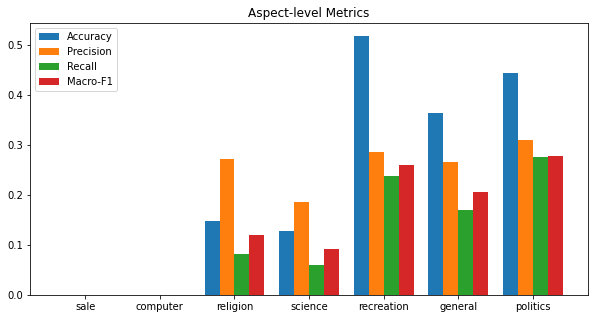

In [60]:
fig, ax  = plt.subplots(1,1, figsize = (10,5))
x = np.arange(7)

width = 0.2

ax.bar(x-3*width/2, df['accuracy'], width, label='Accuracy')
ax.bar(x-width/2, df['precision'], width, label='Precision')
ax.bar(x+width/2, df['recall'], width, label='Recall')
ax.bar(x+3*width/2, df['f1'], width, label='Macro-F1')
ax.set_title('Aspect-level Metrics')

ax.set_xticks(x)
ax.set_xticklabels(df['group'].astype(str).values)
ax.legend()
plt.show()